In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data Preparation

## Loading and Cleaning Full Dataset

In [2]:
"""Make a DataFrame with dates and temperature data for the nine years of the Fresh 15k, at 6:53 am.
Weather data manually retrieved from Weather Underground (https://www.wunderground.com/history/daily/us/tx/tyler/KTYR).

Units: temp and dp are in Fahrenheit, rel. humidity is a percentage, wind speed and gust are in mph,
pressure and precip. are in inches."""

dates = pd.Series(['3/1/14', '3/7/15', '3/5/16', '3/4/17', '3/3/18', '3/2/19', '3/7/20', '5/15/21', '3/5/22'])
weather = pd.DataFrame([[63, 59, 87, 'S', 8, 0, 29.34, 0, 'Cloudy'],
                        [29, 23, 78, 'CALM', 0, 0, 29.86, 0, 'Fair'],
                        [47, 39, 74, 'SSE', 3, 0, 29.55, 0, 'Fair'],
                        [50, 38, 63, 'SE', 3, 0, 29.84, 0, 'Cloudy'],
                        [50, 42, 74, 'ESE', 8, 0, 29.64, 0, 'Partly Cloudy'],
                        [43, 42, 97, 'NNE', 3, 0, 29.51, 0, 'Cloudy'],
                        [47, 30, 52, 'SE', 10, 0, 29.82, 0, 'Fair'],
                        [61, 53, 75, 'S', 6, 0, 29.55, 0, 'Fair'],
                        [64, 60, 87, 'S', 13, 0, 29.38, 0, 'Cloudy'],],
                       columns = ['Temp', 'Dewpoint', 'Relative_humidity', 'Wind_dir',
                                'Wind_speed', 'Wind_gust', 'Pressure', 'Precip', 'Condition'])

weather['Date'] = pd.to_datetime(dates)

weather

,Temp,Dewpoint,Relative_humidity,Wind_dir,Wind_speed,Wind_gust,Pressure,Precip,Condition,Date
0,63,59,87,S,8,0,29.34,0,Cloudy,2014-03-01
1,29,23,78,CALM,0,0,29.86,0,Fair,2015-03-07
2,47,39,74,SSE,3,0,29.55,0,Fair,2016-03-05
3,50,38,63,SE,3,0,29.84,0,Cloudy,2017-03-04
4,50,42,74,ESE,8,0,29.64,0,Partly Cloudy,2018-03-03
5,43,42,97,NNE,3,0,29.51,0,Cloudy,2019-03-02
6,47,30,52,SE,10,0,29.82,0,Fair,2020-03-07
7,61,53,75,S,6,0,29.55,0,Fair,2021-05-15
8,64,60,87,S,13,0,29.38,0,Cloudy,2022-03-05


In [3]:
"""Adds a 'Humidex' columns to weather, to combine temp and dewpoint into one measure.
Humidex is the Canadian version of heat index, and more appropriate for our use since it is well-defined and used
at temperatures below 80 (as low as 15C=59F). Formula from https://en.wikipedia.org/wiki/Humidex.
A perhaps better derived attribute than humidex would be something more specific to vigorous exercise,
but the values below look reasonable to me for this length of race and these temperature ranges."""

temp_cel = (5/9) * (weather['Temp'] - 32)
dp_cel = (5/9) * (weather['Dewpoint'] - 32)
humidex_cel = temp_cel.copy(deep=True)
formula = temp_cel + (5/9) * (6.11 * np.exp(5417.7530 * (1/273.15 - 1/(273.15 + dp_cel))) - 10)
humidex_cel = humidex_cel.mask(temp_cel >= 15, formula)
humidex_fahr = round((9/5) * humidex_cel + 32, 0).astype(int)

weather['Humidex'] = humidex_fahr
weather

,Temp,Dewpoint,Relative_humidity,Wind_dir,Wind_speed,Wind_gust,Pressure,Precip,Condition,Date,Humidex
0,63,59,87,S,8,0,29.34,0,Cloudy,2014-03-01,70
1,29,23,78,CALM,0,0,29.86,0,Fair,2015-03-07,29
2,47,39,74,SSE,3,0,29.55,0,Fair,2016-03-05,47
3,50,38,63,SE,3,0,29.84,0,Cloudy,2017-03-04,50
4,50,42,74,ESE,8,0,29.64,0,Partly Cloudy,2018-03-03,50
5,43,42,97,NNE,3,0,29.51,0,Cloudy,2019-03-02,43
6,47,30,52,SE,10,0,29.82,0,Fair,2020-03-07,47
7,61,53,75,S,6,0,29.55,0,Fair,2021-05-15,65
8,64,60,87,S,13,0,29.38,0,Cloudy,2022-03-05,72


In [4]:
"""Create the DataFrame: for each year, load the year's results, merge with the corresponding weather,
and tack that onto the full DataFrame."""

df_orig = pd.DataFrame()
for date in weather['Date']:
    year_str = str(date.year)
    year_results = pd.read_csv(f'{year_str}_fresh15.csv')
    year_results['Date'] = date
    year_results['Year'] = year_str
    year_results = pd.merge(year_results, weather)
    df_orig = pd.concat([df_orig, year_results], ignore_index=True)

df = df_orig.copy(deep=True)

In [5]:
"""A check that df was built correctly. These numbers do indeed match with the known yearly counts."""

df['Date'].value_counts().sort_index()

2014-03-01     791
2015-03-07    1124
2016-03-05    1215
2017-03-04    1320
2018-03-03    1129
2019-03-02    1089
2020-03-07    1162
2021-05-15     932
2022-03-05     804
Name: Date, dtype: int64

In [6]:
"""Some basic info about non-null counts."""

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9566 entries, 0 to 9565
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Place              9532 non-null   float64       
 1   Div                9562 non-null   object        
 2   Div_place          9528 non-null   float64       
 3   Name               9566 non-null   object        
 4   Age                9562 non-null   float64       
 5   City               9521 non-null   object        
 6   State              9520 non-null   object        
 7   Bib                9566 non-null   int64         
 8   10k_split          9499 non-null   object        
 9   Time               9532 non-null   object        
 10  Date               9566 non-null   datetime64[ns]
 11  Year               9566 non-null   object        
 12  Temp               9566 non-null   int64         
 13  Dewpoint           9566 non-null   int64         
 14  Relative

In [7]:
"""Drop some variables we won't use."""

dropped_vars = ['Name', 'Bib', 'Wind_gust', 'Precip']

df = df.drop(dropped_vars, axis=1, errors='ignore')

In [8]:
"""Check that df looks as expected."""

bottom_2015 = df[pd.DatetimeIndex(df['Date']).year == 2015].tail()
top_2016 = df[pd.DatetimeIndex(df['Date']).year == 2016].head()
example_data = pd.concat([bottom_2015, top_2016])
example_data

,Place,Div,Div_place,Age,City,State,10k_split,Time,Date,Year,Temp,Dewpoint,Relative_humidity,Wind_dir,Wind_speed,Pressure,Condition,Humidex,5k_split,Last_5k_split
1910,NaN,F 40-44,NaN,43.0,TYLER,TX,NaN,NaN,2015-03-07,2015,29,23,78,CALM,0,29.86,Fair,29,28:55,NaN
1911,NaN,F 25-29,NaN,27.0,TYLER,TX,NaN,NaN,2015-03-07,2015,29,23,78,CALM,0,29.86,Fair,29,30:21,NaN
1912,NaN,F 1-19,NaN,12.0,MEXIA,TX,NaN,NaN,2015-03-07,2015,29,23,78,CALM,0,29.86,Fair,29,47:50,NaN
1913,NaN,F 20-24,NaN,24.0,TYLER,TX,NaN,NaN,2015-03-07,2015,29,23,78,CALM,0,29.86,Fair,29,48:35,NaN
1914,NaN,F 45-49,NaN,45.0,HOT SPRINGS,AR,NaN,NaN,2015-03-07,2015,29,23,78,CALM,0,29.86,Fair,29,49:55,NaN
1915,1.0,M 30-34,1.0,30.0,CHAPEL HILL,NC,28:45,44:13,2016-03-05,2016,47,39,74,SSE,3,29.55,Fair,47,14:22,15:28
1916,2.0,M 30-34,2.0,30.0,CHAPEL HILL,NC,29:01,44:14,2016-03-05,2016,47,39,74,SSE,3,29.55,Fair,47,14:22,15:14
1917,3.0,M 25-29,1.0,25.0,GRAND PRAIRIE,TX,28:46,44:21,2016-03-05,2016,47,39,74,SSE,3,29.55,Fair,47,14:22,15:36
1918,4.0,M 30-34,3.0,33.0,HEBRON,KY,29:06,44:57,2016-03-05,2016,47,39,74,SSE,3,29.55,Fair,47,14:22,15:52
1919,5.0,M 35-39,1.0,36.0,CHAPEL HILL,NC,29:15,45:08,2016-03-05,2016,47,39,74,SSE,3,29.55,Fair,47,14:22,15:53


In [9]:
"""Extract gender and age group range from the 'Div' variable, and then drop 'Div'.
Check that the resulting age groups are sensible for analysis purposes."""

df['Gender'] = df['Div'].str.extract(r'([MF])')
df['Age_group'] = df['Div'].str.extract(r'(\d+-\d+)')
df = df.drop('Div', axis=1)

df['Age_group'].unique()

array(['20-29', '30-39', '40-49', '50-59', '15-19', nan, '1-14', '60-69',
       '25-29', '20-24', '35-39', '30-34', '40-44', '45-49', '1-19',
       '55-59', '50-54', '60-64', '70-74', '65-69', '75-79', '80-89'],
      dtype=object)

These are not sensible -- it looks like different editions of the race reported different age groups.
We'll drop these and make our own age groups based on 'Age', which will be time_deltas so that we can order them.
We'll retain 'Age' in case we want to look more specifically at this info.

In [10]:
"""Get the maximum age."""

df['Age'].max()

99.0

In [11]:
"""Drop 'Age_group', then rebuild it using decade ranges."""

df = df.drop('Age_group', axis=1)
for start_age in range(0, 100, 10):
    decade_mask = (start_age <= df['Age']) & (df['Age'] < start_age + 10)
    df.loc[decade_mask, 'Age_group'] = str(start_age) + '-' + str(start_age + 9)

df['Age_group'].unique()

array(['20-29', '30-39', '40-49', '50-59', '10-19', '80-89', '60-69',
       '90-99', '70-79', nan, '0-9'], dtype=object)

In [12]:
"""Add a coarse age_group variable to make the plotting and analysis simpler."""

for start_age in [0, 20, 40]:
    twenty_year_mask = (start_age <= df['Age']) & (df['Age'] < start_age + 20)
    df.loc[twenty_year_mask, 'Coarse_age_group'] = str(start_age) + '-' + str(start_age + 19)
start_age = 60
older_mask = (start_age <= df['Age'])
df.loc[older_mask, 'Coarse_age_group'] = str(start_age) + '+'

df['Coarse_age_group'].unique()

array(['20-39', '40-59', '0-19', '60+', nan], dtype=object)

In [13]:
"""Adjust all times to H:MM:SS format then convert to type timedelta (the try-except is so I can re-run this cell with no problems)
followed by a check that this did the desired thing."""

time_columns = ['5k_split', '10k_split', 'Last_5k_split', 'Time']
try:
    for column in time_columns:
        under_hour_mask = df[column].str.match(r'\d\d:\d\d', na=False)
        df.loc[under_hour_mask, column] = '0:' + df[column]
        df[column] = pd.to_timedelta(df[column])
except:
    pass

bottom_2015 = df[pd.DatetimeIndex(df['Date']).year == 2015].tail()
top_2016 = df[pd.DatetimeIndex(df['Date']).year == 2016].head()
example_data = pd.concat([bottom_2015, top_2016])
example_data[time_columns]

,5k_split,10k_split,Last_5k_split,Time
1910,0 days 00:28:55,NaT,NaT,NaT
1911,0 days 00:30:21,NaT,NaT,NaT
1912,0 days 00:47:50,NaT,NaT,NaT
1913,0 days 00:48:35,NaT,NaT,NaT
1914,0 days 00:49:55,NaT,NaT,NaT
1915,0 days 00:14:22,0 days 00:28:45,0 days 00:15:28,0 days 00:44:13
1916,0 days 00:14:22,0 days 00:29:01,0 days 00:15:14,0 days 00:44:14
1917,0 days 00:14:22,0 days 00:28:46,0 days 00:15:36,0 days 00:44:21
1918,0 days 00:14:22,0 days 00:29:06,0 days 00:15:52,0 days 00:44:57
1919,0 days 00:14:22,0 days 00:29:15,0 days 00:15:53,0 days 00:45:08


In [14]:
"""Since the 2014 data only provides a 10k split, we fill in 5k_split and Last_5k_split data
with estimates."""

mask = df['Year'] == '2014'
df.loc[mask, '5k_split'] = 0.5 * df.loc[mask, '10k_split']
df.loc[mask, 'Last_5k_split'] = df.loc[mask, 'Time'] - df.loc[mask, '10k_split']
df[mask]

,Place,Div_place,Age,City,State,10k_split,Time,Date,Year,Temp,...,Wind_dir,Wind_speed,Pressure,Condition,Humidex,5k_split,Last_5k_split,Gender,Age_group,Coarse_age_group
0,1.0,1.0,28.0,RICHARDSON,TX,0 days 00:31:45,0 days 00:48:31,2014-03-01,2014,63,...,S,8,29.34,Cloudy,70,0 days 00:15:52.500000,0 days 00:16:46,M,20-29,20-39
1,2.0,1.0,30.0,IRVING,TX,0 days 00:31:50,0 days 00:48:58,2014-03-01,2014,63,...,S,8,29.34,Cloudy,70,0 days 00:15:55,0 days 00:17:08,M,30-39,20-39
2,3.0,2.0,28.0,DALLAS,TX,0 days 00:32:15,0 days 00:49:23,2014-03-01,2014,63,...,S,8,29.34,Cloudy,70,0 days 00:16:07.500000,0 days 00:17:08,M,20-29,20-39
3,4.0,3.0,29.0,TYLER,TX,0 days 00:33:06,0 days 00:50:04,2014-03-01,2014,63,...,S,8,29.34,Cloudy,70,0 days 00:16:33,0 days 00:16:58,M,20-29,20-39
4,5.0,2.0,31.0,NORMAN,OK,0 days 00:33:06,0 days 00:50:08,2014-03-01,2014,63,...,S,8,29.34,Cloudy,70,0 days 00:16:33,0 days 00:17:02,M,30-39,20-39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,787.0,38.0,54.0,RUSK,TX,0 days 01:41:20,0 days 02:34:01,2014-03-01,2014,63,...,S,8,29.34,Cloudy,70,0 days 00:50:40,0 days 00:52:41,F,50-59,40-59
787,788.0,106.0,40.0,ASHDOWN,AR,0 days 01:41:34,0 days 02:34:42,2014-03-01,2014,63,...,S,8,29.34,Cloudy,70,0 days 00:50:47,0 days 00:53:08,F,40-49,40-59
788,789.0,119.0,31.0,TYLER,TX,0 days 01:42:08,0 days 02:39:38,2014-03-01,2014,63,...,S,8,29.34,Cloudy,70,0 days 00:51:04,0 days 00:57:30,F,30-39,20-39
789,790.0,107.0,49.0,TYLER,TX,0 days 01:43:37,0 days 02:40:26,2014-03-01,2014,63,...,S,8,29.34,Cloudy,70,0 days 00:51:48.500000,0 days 00:56:49,F,40-49,40-59


In [15]:
"""Add some variables concerning splits and over/under split differential."""

df['Middle_5k_split'] = df['10k_split'] - df['5k_split']
df['First_half_est'] = df['5k_split'] + 0.5 * df['Middle_5k_split']
df['Second_half_est'] = df['Last_5k_split'] + 0.5 * df['Middle_5k_split']
df['Half_differential'] = df['Second_half_est'] - df['First_half_est']
df['First_two_thirds_differential'] = df['Middle_5k_split'] - df['5k_split']
df['Last_two_thirds_differential'] = df['Last_5k_split'] - df['Middle_5k_split']

In [16]:
"""Convert times to minutes or seconds, depending on which is more easily intepreted."""

time_columns_min = ['5k_split', '10k_split', 'Last_5k_split', 'Time',
               'Middle_5k_split', 'First_half_est', 'Second_half_est']
time_columns_sec = ['Half_differential', 'First_two_thirds_differential', 'Last_two_thirds_differential']

for column in time_columns_min:
    df[column + '_min'] = df[column].dt.total_seconds() / 60
for column in time_columns_sec:
    df[column + '_sec'] = df[column].dt.total_seconds()

bottom_2015 = df[pd.DatetimeIndex(df['Date']).year == 2015].tail()
top_2016 = df[pd.DatetimeIndex(df['Date']).year == 2016].head()
example_data = pd.concat([bottom_2015, top_2016])
example_data[time_columns]

,5k_split,10k_split,Last_5k_split,Time
1910,0 days 00:28:55,NaT,NaT,NaT
1911,0 days 00:30:21,NaT,NaT,NaT
1912,0 days 00:47:50,NaT,NaT,NaT
1913,0 days 00:48:35,NaT,NaT,NaT
1914,0 days 00:49:55,NaT,NaT,NaT
1915,0 days 00:14:22,0 days 00:28:45,0 days 00:15:28,0 days 00:44:13
1916,0 days 00:14:22,0 days 00:29:01,0 days 00:15:14,0 days 00:44:14
1917,0 days 00:14:22,0 days 00:28:46,0 days 00:15:36,0 days 00:44:21
1918,0 days 00:14:22,0 days 00:29:06,0 days 00:15:52,0 days 00:44:57
1919,0 days 00:14:22,0 days 00:29:15,0 days 00:15:53,0 days 00:45:08


In [17]:
"""Add a variable for split differential scaled by overall time (the idea being that a two-minute positive split
for someone running 45 minutes is much worse than the same differential for someone running two hours.)"""

df['Split_scaled'] = df['Half_differential_sec'] / df['Time_min']

df['Split_scaled'][:10]

0    1.102714
1    1.490810
2    1.225110
3    0.499334
4    0.578457
5    0.834161
6    1.361855
7    1.592417
8    1.255112
9    0.965625
Name: Split_scaled, dtype: float64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9566 entries, 0 to 9565
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype          
---  ------                             --------------  -----          
 0   Place                              9532 non-null   float64        
 1   Div_place                          9528 non-null   float64        
 2   Age                                9562 non-null   float64        
 3   City                               9521 non-null   object         
 4   State                              9520 non-null   object         
 5   10k_split                          9499 non-null   timedelta64[ns]
 6   Time                               9532 non-null   timedelta64[ns]
 7   Date                               9566 non-null   datetime64[ns] 
 8   Year                               9566 non-null   object         
 9   Temp                               9566 non-null   int64          
 10  Dewpoint                

In [19]:
"""For ease of looking at specific rows later, we define a subset of core columns."""
core_vars = ['5k_split_min', '10k_split_min', 'Time_min',
             'Half_differential_sec', 'Gender', 'Age', 'Year']

# Graphical Visualizations of the Data

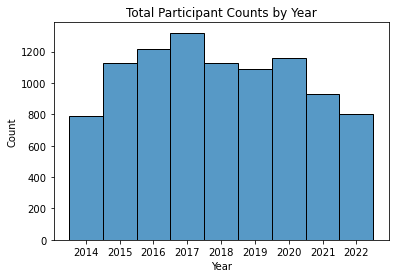

In [20]:
sns.histplot(data=df, x='Year');
plt.title('Total Participant Counts by Year');

## Gender

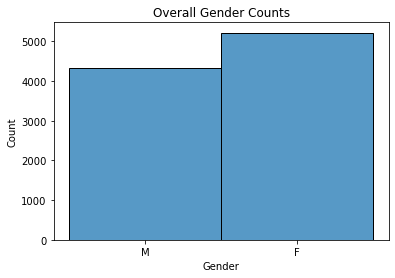

In [21]:
sns.histplot(data=df, x='Gender');
plt.title('Overall Gender Counts');

From the following, we see for example that the years with the most even gender distributions were the first and most recent, and the most uneven year was 2017:

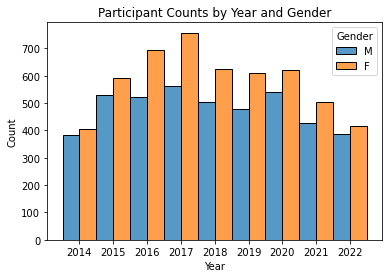

In [22]:
sns.histplot(data=df, x='Year', hue='Gender', multiple='dodge');
plt.title('Participant Counts by Year and Gender');

In [23]:
year_gender = df.groupby(['Year', 'Gender'])['Gender'].agg('count')
year_gender = year_gender.unstack()
year_gender['Female proportion'] = year_gender['F']/(year_gender['F'] + year_gender['M'])
year_gender['Male proportion'] = year_gender['M']/(year_gender['F'] + year_gender['M'])
year_gender.rename(columns = {'F': 'Female count', 'M': 'Male count'}, inplace=True)
year_gender

Gender,Female count,Male count,Female proportion,Male proportion
Year,,,,
2014,404,384,0.512690,0.487310
2015,590,530,0.526786,0.473214
2016,692,523,0.569547,0.430453
2017,757,563,0.573485,0.426515
2018,623,505,0.552305,0.447695
2019,611,478,0.561065,0.438935
2020,619,542,0.533161,0.466839
2021,505,427,0.541845,0.458155
2022,417,386,0.519303,0.480697


## Age

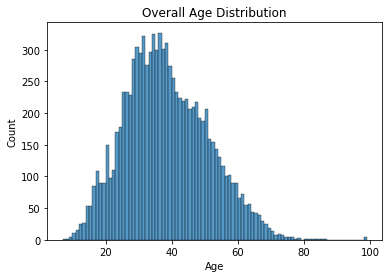

In [24]:
sns.histplot(data=df, x='Age', binwidth=1);
plt.title('Overall Age Distribution');

It looks like there's an odd gap with several high outliers at the same age. Here's the numerical data at the tail:

In [25]:
from collections import Counter
ages = df[df['Age'].notnull()]['Age']

sorted(Counter(ages).items())[-20:]

[(67.0, 29),
 (68.0, 25),
 (69.0, 19),
 (70.0, 14),
 (71.0, 8),
 (72.0, 9),
 (73.0, 7),
 (74.0, 5),
 (75.0, 5),
 (76.0, 5),
 (77.0, 2),
 (78.0, 3),
 (80.0, 2),
 (81.0, 1),
 (82.0, 1),
 (83.0, 1),
 (84.0, 1),
 (85.0, 1),
 (86.0, 1),
 (99.0, 5)]

Based on the time, I'm deeply suspicious that these five people are not actually 99 years old:

In [26]:
df[df['Age'] == 99][core_vars]

,5k_split_min,10k_split_min,Time_min,Half_differential_sec,Gender,Age,Year
255,28.225000,56.450000,85.233333,33.5,NaN,99.0,2014
279,27.825000,55.650000,86.283333,168.5,NaN,99.0,2014
310,28.416667,56.833333,88.316667,184.0,NaN,99.0,2014
5413,33.800000,70.616667,115.933333,691.0,NaN,99.0,2018
6900,28.583333,52.666667,78.033333,-192.0,NaN,99.0,2020


## Gender and Age

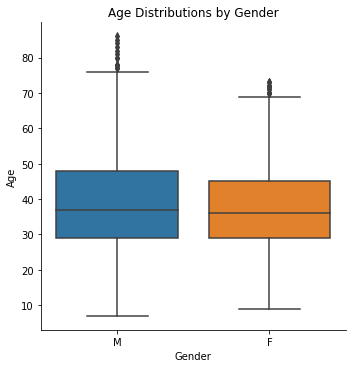

In [27]:
sns.catplot(data=df, x='Gender', y='Age', kind='box');
plt.title('Age Distributions by Gender');

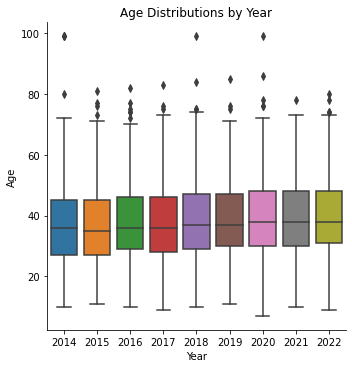

In [28]:
sns.catplot(data=df, x='Year', y='Age', kind='box');
plt.title('Age Distributions by Year');

Perhaps interestingly, the mean and median age have almost progressed almost every year:

In [29]:
df.groupby('Year')['Age'].agg(['mean', 'median', 'std'])

,mean,median,std
Year,,,
2014,36.663717,36.0,12.546952
2015,36.619643,35.0,11.988301
2016,37.367078,36.0,12.200018
2017,37.253788,36.0,12.603295
2018,38.170062,37.0,12.815499
2019,38.680441,37.0,12.166386
2020,38.901893,38.0,12.912573
2021,39.190987,38.0,12.550906
2022,39.629353,38.0,12.738365


From the following, it looks like the age increase is coming from both genders:

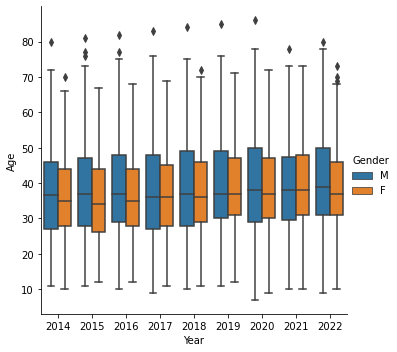

In [30]:
sns.catplot(data=df, x='Year', y='Age', hue='Gender', kind='box');

In [31]:
print('Male Ages by Year\n',
      df[df['Gender'] == 'M'].groupby('Year')['Age'].agg(['mean', 'median', 'std']), '\n')
print('Female Ages by Year\n',
      df[df['Gender'] == 'F'].groupby('Year')['Age'].agg(['mean', 'median', 'std']))

Male Ages by Year
            mean  median        std
Year                              
2014  37.049479    36.5  12.927601
2015  37.866038    37.0  12.720902
2016  38.575526    37.0  13.626642
2017  37.245115    36.0  14.065567
2018  38.655446    37.0  14.107724
2019  38.822176    37.0  13.359713
2020  39.047970    38.0  13.984197
2021  39.046838    38.0  13.503005
2022  40.784974    39.0  13.823296 

Female Ages by Year
            mean  median        std
Year                              
2014  35.834158    35.0  10.955118
2015  35.500000    34.0  11.182655
2016  36.453757    35.0  10.921607
2017  37.260238    36.0  11.404523
2018  37.678973    36.0  11.410197
2019  38.569558    37.0  11.154195
2020  38.676898    37.0  11.667410
2021  39.312871    38.0  11.697796
2022  38.568345    37.0  11.574830


## Time and Split Distributions

We restrict attention to overall time and the estimated half differential, and look at the relationships between these, gender, age, and the weather.

In [32]:
time_cols = ['Time_min', 'Half_differential_sec']

df[time_cols].describe()

,Time_min,Half_differential_sec
count,9532.000000,9456.000000
mean,94.711003,186.903606
std,20.894506,213.562625
min,43.366667,-1121.000000
25%,80.712500,51.000000
50%,92.383333,141.000000
75%,106.416667,285.000000
max,178.100000,3983.000000


### Overall Time

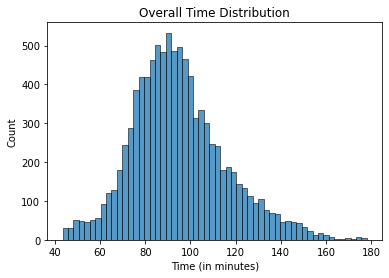

In [33]:
sns.histplot(data=df, x='Time_min');
plt.xlabel('Time (in minutes)');
plt.title('Overall Time Distribution');

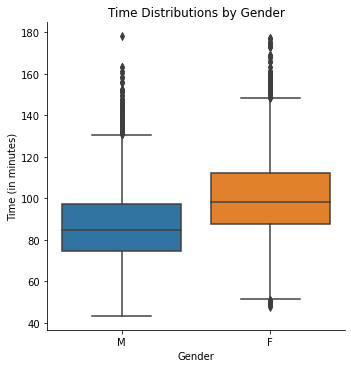

In [34]:
sns.catplot(data=df, x='Gender', y='Time_min', kind='box');
plt.ylabel('Time (in minutes)');
plt.title('Time Distributions by Gender');

The following is another view on essentially the same thing. (The gender distributions in the following were normalized independently, which removes the size difference between the genders.)

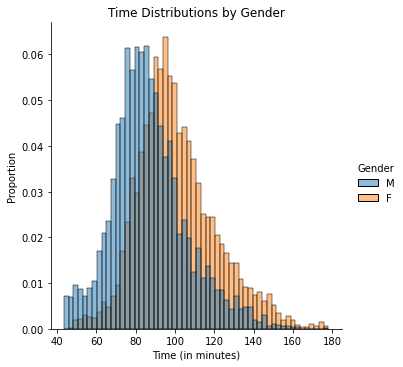

In [35]:
sns.displot(df, x='Time_min', hue='Gender', stat='proportion', common_norm=False);
plt.xlabel('Time (in minutes)');
plt.title('Time Distributions by Gender');

Now we look at the relationship between overall time and age. Since there were only a few people in the 0-9, 80-89, and 90-99 age groups (the latter of which were probably not accurate anyway), these age groups are omitted.

In [36]:
df.value_counts('Age_group')

Age_group
30-39    3027
40-49    2169
20-29    1989
50-59    1293
10-19     557
60-69     450
70-79      58
80-89       8
0-9         6
90-99       5
dtype: int64

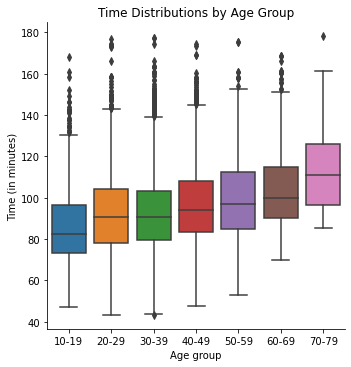

In [37]:
sns.catplot(data=df, x='Age_group', y='Time_min', kind='box',
           order=['10-19', '20-29', '30-39', '40-49', '50-59',
                 '60-69', '70-79']);
plt.ylabel('Time (in minutes)');
plt.xlabel('Age group');
plt.title('Time Distributions by Age Group');

This is another view of overall time distributions by age, but less easy to read, even after reducing down to just four age groups.

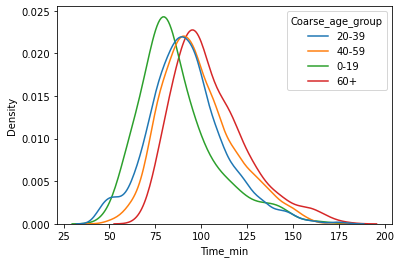

In [38]:
sns.kdeplot(data=df, x='Time_min', hue='Coarse_age_group', common_norm=False);

The following isn't perfect (it would maybe be better to space the temperatures to scale), but at least gives an idea of how the times vary by weather conditions, which is apparently not much in the data here, but we'll investigate this more deeply later with statistical techniques.

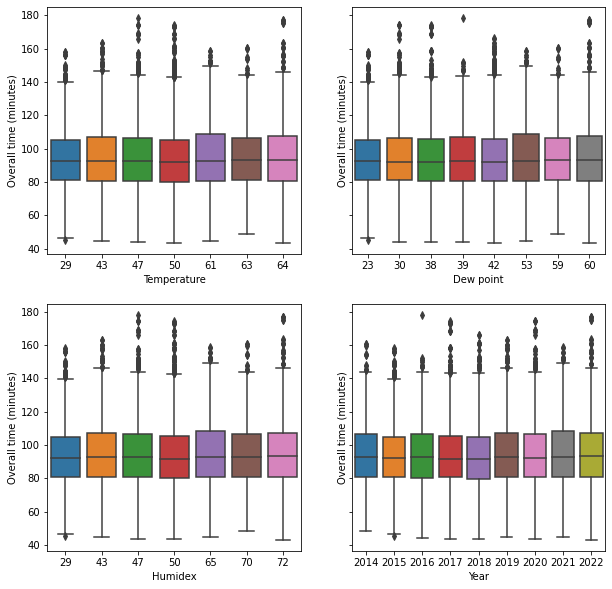

In [39]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(10,10));
sns.boxplot(data=df, x='Temp', y='Time_min', ax=ax1);
sns.boxplot(data=df, x='Dewpoint', y='Time_min', ax=ax2);
sns.boxplot(data=df, x='Humidex', y='Time_min', ax=ax3);
sns.boxplot(data=df, x='Year', y='Time_min', ax=ax4);
ax1.set_xlabel('Temperature');
ax2.set_xlabel('Dew point');
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylabel('Overall time (minutes)');

Here we try to see more clearly the relationship between the weather variables and overall time by focusing on the medians.

In [40]:
# Create the relevant DataFrame.

year_aggs = df.groupby('Year')[['Time_min', 'Half_differential_sec', 'Split_scaled']].median()
year_aggs.columns = ['Time_min_median', 'Half_diff_sec_median', 'Split_scaled_median']
year_weather = pd.DataFrame(weather[['Temp', 'Dewpoint', 'Humidex']])
year_weather.index = np.arange(2014, 2023).astype(str)
year_aggs = pd.concat([year_aggs, year_weather], axis=1)
year_aggs['Year'] = year_aggs.index.astype(int)
year_aggs

,Time_min_median,Half_diff_sec_median,Split_scaled_median,Temp,Dewpoint,Humidex,Year
2014,92.916667,149.0,1.642093,63,59,70,2014
2015,92.350000,129.0,1.497749,29,23,29,2015
2016,92.800000,158.0,1.813217,47,39,47,2016
2017,91.850000,126.0,1.424180,50,38,50,2017
2018,91.616667,130.0,1.519155,50,42,50,2018
2019,92.850000,120.0,1.387378,43,42,43,2019
2020,92.166667,112.0,1.300174,47,30,47,2020
2021,92.716667,190.5,2.078037,61,53,65,2021
2022,93.366667,173.0,1.904696,64,60,72,2022


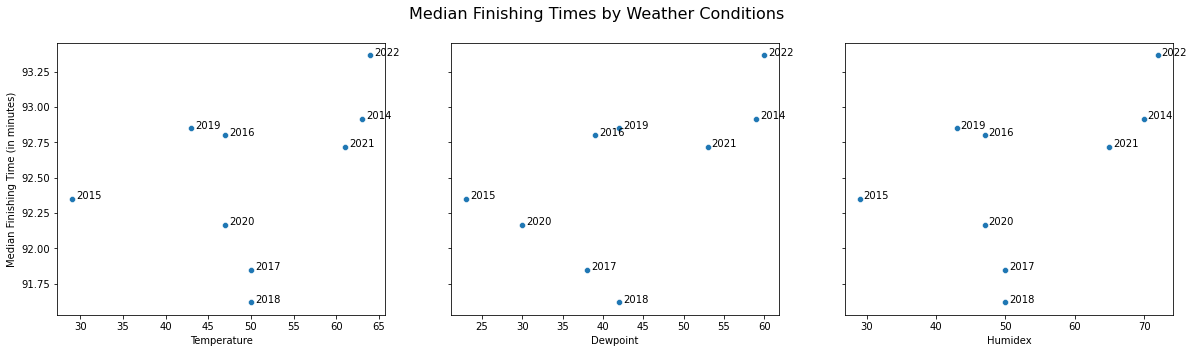

In [41]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + .5, point['y'], str(point['val']))

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20,5));
weather_vars = ['Temp', 'Dewpoint', 'Humidex']
for k in range(3):
    sns.scatterplot(data=year_aggs, x=weather_vars[k], y='Time_min_median', ax=axs[k]);
    label_point(year_aggs[weather_vars[k]], year_aggs['Time_min_median'], year_aggs['Year'].astype(str), axs[k]);
axs[0].set_ylabel('Median Finishing Time (in minutes)');
axs[0].set_xlabel('Temperature');
fig.suptitle('Median Finishing Times by Weather Conditions', fontsize=16);

So it looks like there is maybe a very loose correlation. Spoiler: We'll see later that none of the weather statistics are significantly (linearly) correlated with overall finishing times.

### Half Split Differential

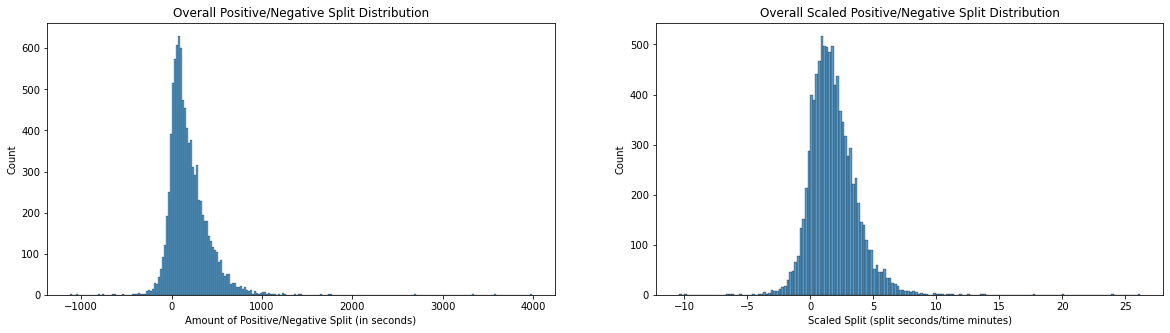

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20,5));

sns.histplot(data=df, x='Half_differential_sec', ax=ax1);
ax1.set_xlabel('Amount of Positive/Negative Split (in seconds)');
ax1.set_title('Overall Positive/Negative Split Distribution');

sns.histplot(data=df, x='Split_scaled', ax=ax2);
ax2.set_xlabel('Scaled Split (split seconds/time minutes)');
ax2.set_title('Overall Scaled Positive/Negative Split Distribution');

Whoa, some people have crazy high positive splits. Here are the most extreme positive splits:

In [43]:
pos_splitters = df.sort_values(by='Half_differential_sec', na_position='first')[core_vars]
pos_splitters['Half_differential_min'] = pos_splitters['Half_differential_sec'] / 60
pos_splitters.iloc[-1:-20:-1]

,5k_split_min,10k_split_min,Time_min,Half_differential_sec,Gender,Age,Year,Half_differential_min
7818,28.816667,56.933333,152.116667,3983.0,M,51.0,2020,66.383333
6649,28.650000,61.583333,149.950000,3584.0,F,32.0,2019,59.733333
5576,37.416667,73.300000,166.300000,3336.0,F,28.0,2018,55.600000
6653,31.900000,74.883333,151.566667,2687.0,M,24.0,2019,44.783333
4353,32.583333,66.866667,128.850000,1765.0,F,45.0,2017,29.416667
8751,39.700000,87.200000,156.033333,1748.0,F,43.0,2021,29.133333
751,34.225000,68.450000,130.116667,1646.5,M,26.0,2014,27.441667
1868,36.300000,77.816667,138.000000,1433.0,M,59.0,2015,23.883333
5246,24.400000,53.983333,101.850000,1408.0,M,14.0,2018,23.466667
6475,23.433333,67.483333,113.633333,1364.0,M,50.0,2019,22.733333


The following is the same chart as the previous one, but clipped to the main part of the distributions. Generally, we'll remove outliers for this variables in the following.

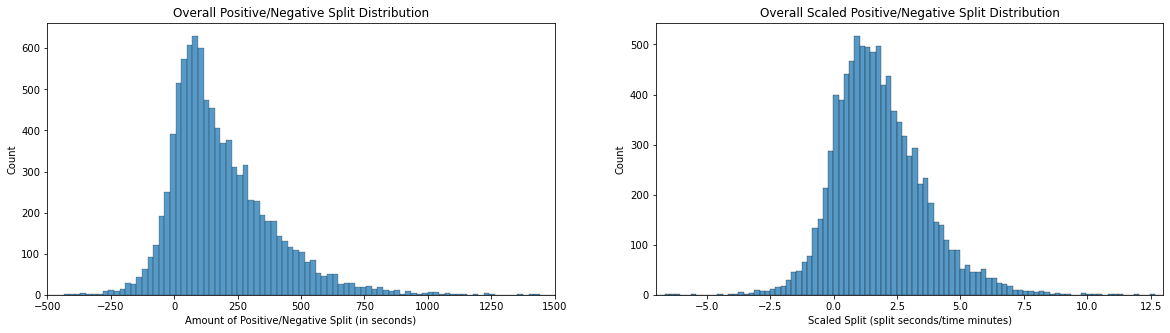

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20,5));

sns.histplot(data=df, x='Half_differential_sec', ax=ax1);
ax1.set_xlabel('Amount of Positive/Negative Split (in seconds)');
ax1.set_title('Overall Positive/Negative Split Distribution');
ax1.set_xlim(-500,1500);

sns.histplot(data=df, x='Split_scaled', ax=ax2);
ax2.set_xlabel('Scaled Split (split seconds/time minutes)');
ax2.set_title('Overall Scaled Positive/Negative Split Distribution');
ax2.set_xlim(-7,13);

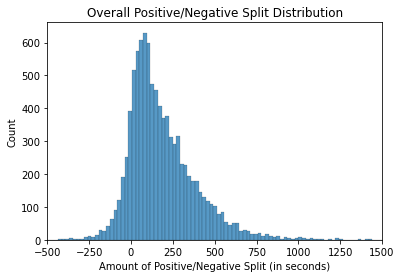

In [45]:
sns.histplot(data=df, x='Half_differential_sec');
plt.xlabel('Amount of Positive/Negative Split (in seconds)');
plt.title('Overall Positive/Negative Split Distribution');
plt.xlim(-500,1500);

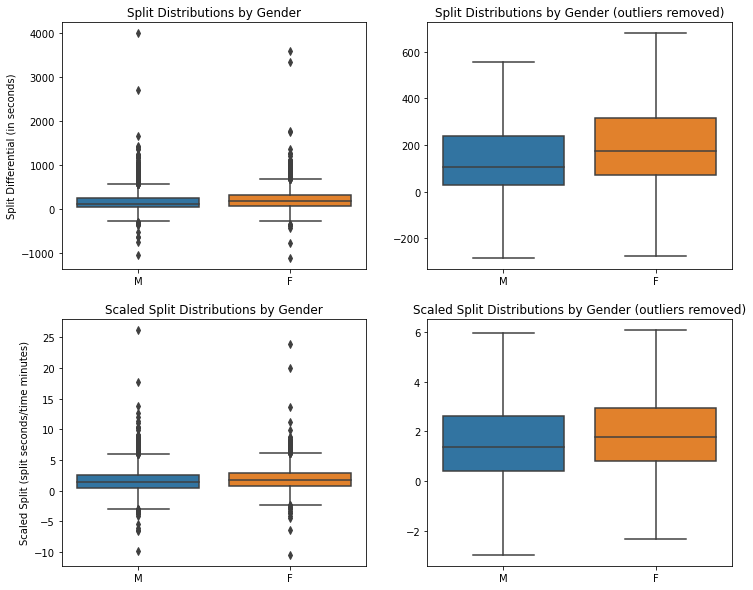

In [46]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(12,10));

sns.boxplot(data=df, x='Gender', y='Half_differential_sec', showfliers=True, ax=axs[0][0]);
axs[0][0].set_xlabel('');
axs[0][0].set_title('Split Distributions by Gender');
axs[0][0].set_ylabel('Split Differential (in seconds)');

sns.boxplot(data=df, x='Gender', y='Half_differential_sec', showfliers=False, ax=axs[0][1]);
axs[0][1].set_xlabel('');
axs[0][1].set_ylabel('');
axs[0][1].set_title('Split Distributions by Gender (outliers removed)');

sns.boxplot(data=df, x='Gender', y='Split_scaled', showfliers=True, ax=axs[1][0]);
axs[1][0].set_xlabel('');
axs[1][0].set_title('Scaled Split Distributions by Gender');
axs[1][0].set_ylabel('Scaled Split (split seconds/time minutes)');

sns.boxplot(data=df, x='Gender', y='Split_scaled', showfliers=False, ax=axs[1][1]);
axs[1][1].set_xlabel('');
axs[1][1].set_ylabel('');
axs[1][1].set_title('Scaled Split Distributions by Gender (outliers removed)');

It's interesting to note from the above that females generally have more positive splits than males, but some of this difference is washed out in the scaled data.

The following is a more detailed view on the above. As with the overall time histogram by gender above, the gender distributions were normalized independently, which removes the size difference between the genders.

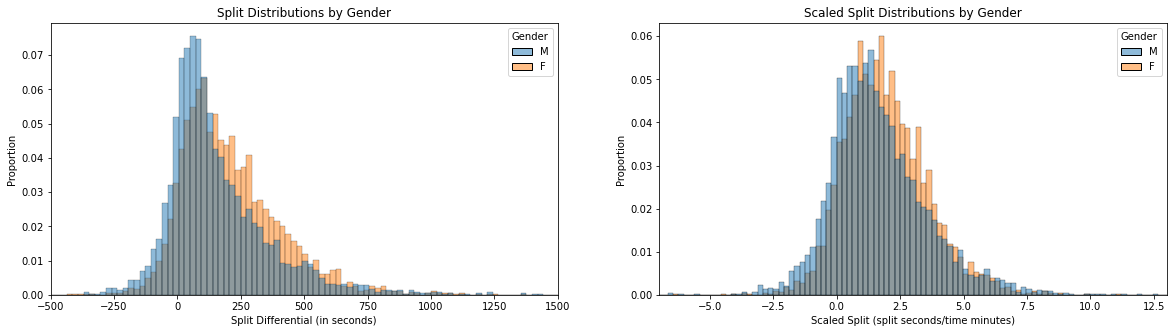

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20,5));

sns.histplot(data=df, x='Half_differential_sec', hue='Gender', stat='proportion', common_norm=False, ax=ax1);
ax1.set_xlim(-500, 1500);
ax1.set_xlabel('Split Differential (in seconds)');
ax1.set_title('Split Distributions by Gender');

sns.histplot(data=df, x='Split_scaled', hue='Gender', stat='proportion', common_norm=False, ax=ax2);
ax2.set_xlim(-7, 13);
ax2.set_xlabel('Scaled Split (split seconds/time minutes)');
ax2.set_title('Scaled Split Distributions by Gender');

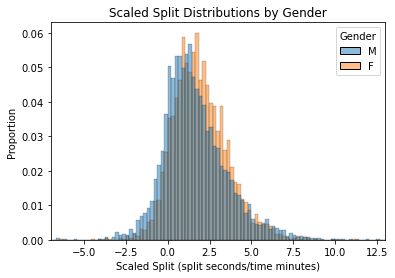

In [48]:
sns.histplot(data=df, x='Split_scaled', hue='Gender', stat='proportion', common_norm=False);
plt.xlim(-7, 13);
plt.xlabel('Scaled Split (split seconds/time minutes)');
plt.title('Scaled Split Distributions by Gender');

The following is pretty interesting: there's an apparent positive correlation between age and raw split differential, but much of that vanishes after scaling. We'll see in the statistical analysis later how predictive age really is for splits.

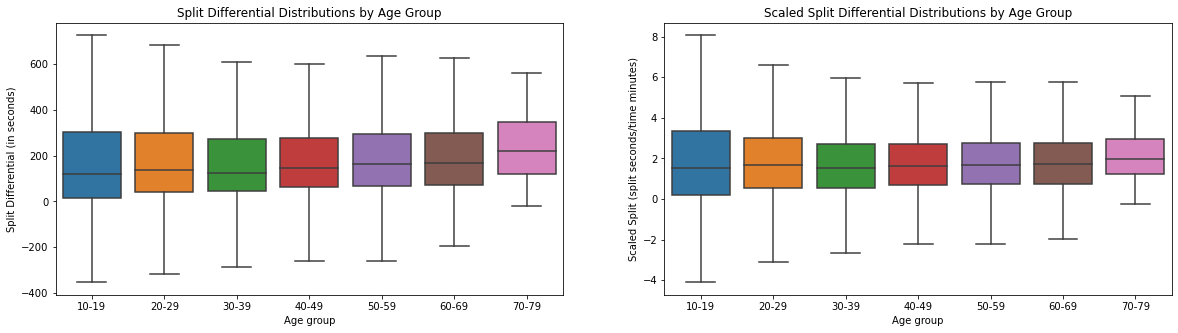

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20,5));

sns.boxplot(data=df, x='Age_group', y='Half_differential_sec', showfliers=False, ax=ax1,
           order=['10-19', '20-29', '30-39', '40-49', '50-59',
                 '60-69', '70-79']);
ax1.set_ylabel('Split Differential (in seconds)');
ax1.set_xlabel('Age group');
ax1.set_title('Split Differential Distributions by Age Group');

sns.boxplot(data=df, x='Age_group', y='Split_scaled', showfliers=False, ax=ax2,
           order=['10-19', '20-29', '30-39', '40-49', '50-59',
                 '60-69', '70-79']);
ax2.set_ylabel('Scaled Split (split seconds/time minutes)');
ax2.set_xlabel('Age group');
ax2.set_title('Scaled Split Differential Distributions by Age Group');

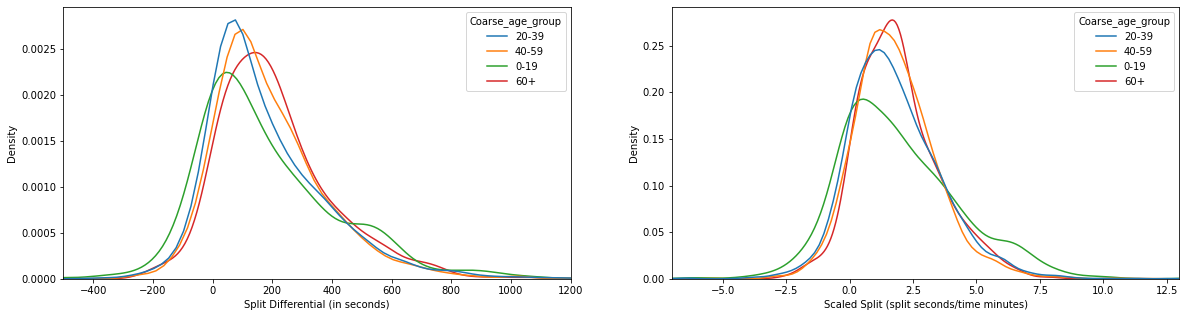

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20,5));

sns.kdeplot(data=df, x='Half_differential_sec', hue='Coarse_age_group', common_norm=False, ax=ax1);
ax1.set_xlim(-500, 1200);
ax1.set_xlabel('Split Differential (in seconds)');

sns.kdeplot(data=df, x='Split_scaled', hue='Coarse_age_group', common_norm=False, ax=ax2);
ax2.set_xlim(-7, 13);
ax2.set_xlabel('Scaled Split (split seconds/time minutes)');

From the following, it does look like warmer weather conditions affect the split differentials (unlike overall time, which was surprising), and scaling doesn't seem to change things here.

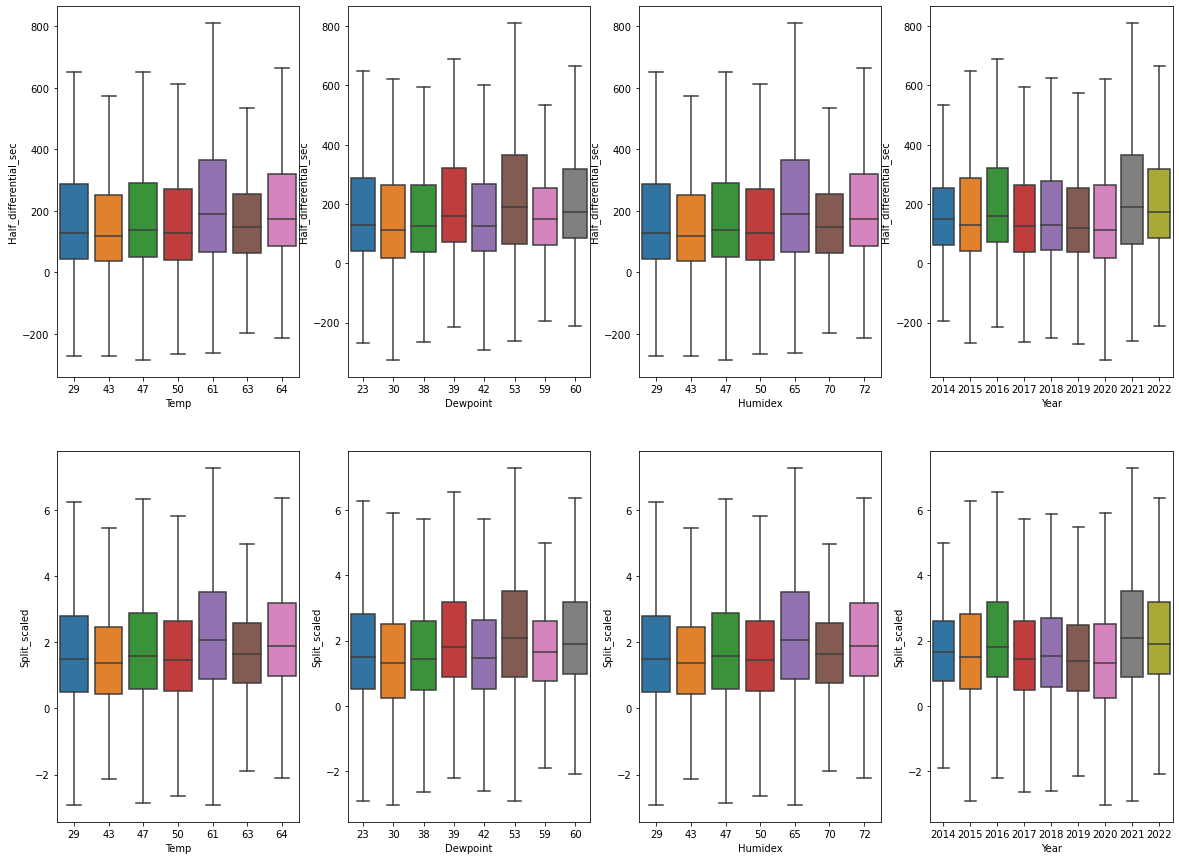

In [51]:
fig, axs = plt.subplots(2, 4, sharey=False, figsize=(20,15));

sns.boxplot(data=df, x='Temp', y='Half_differential_sec', showfliers=False, ax=axs[0][0]);
sns.boxplot(data=df, x='Dewpoint', y='Half_differential_sec', showfliers=False, ax=axs[0][1]);
sns.boxplot(data=df, x='Humidex', y='Half_differential_sec', showfliers=False, ax=axs[0][2]);
sns.boxplot(data=df, x='Year', y='Half_differential_sec', showfliers=False, ax=axs[0][3]);

sns.boxplot(data=df, x='Temp', y='Split_scaled', showfliers=False, ax=axs[1][0]);
sns.boxplot(data=df, x='Dewpoint', y='Split_scaled', showfliers=False, ax=axs[1][1]);
sns.boxplot(data=df, x='Humidex', y='Split_scaled', showfliers=False, ax=axs[1][2]);
sns.boxplot(data=df, x='Year', y='Split_scaled', showfliers=False, ax=axs[1][3]);

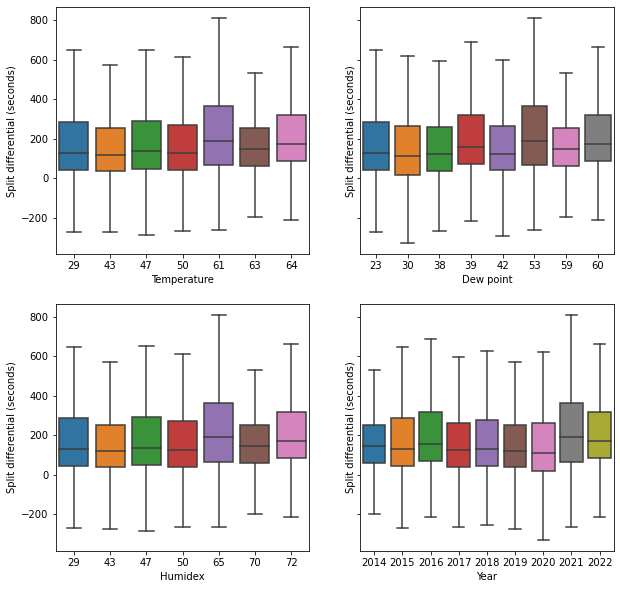

In [52]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(10,10));
sns.boxplot(data=df, x='Temp', y='Half_differential_sec', showfliers=False, ax=ax1);
sns.boxplot(data=df, x='Dewpoint', y='Half_differential_sec', showfliers=False, ax=ax2);
sns.boxplot(data=df, x='Humidex', y='Half_differential_sec', showfliers=False, ax=ax3);
sns.boxplot(data=df, x='Year', y='Half_differential_sec',showfliers=False, ax=ax4);
ax1.set_xlabel('Temperature');
ax2.set_xlabel('Dew point');
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylabel('Split differential (seconds)');

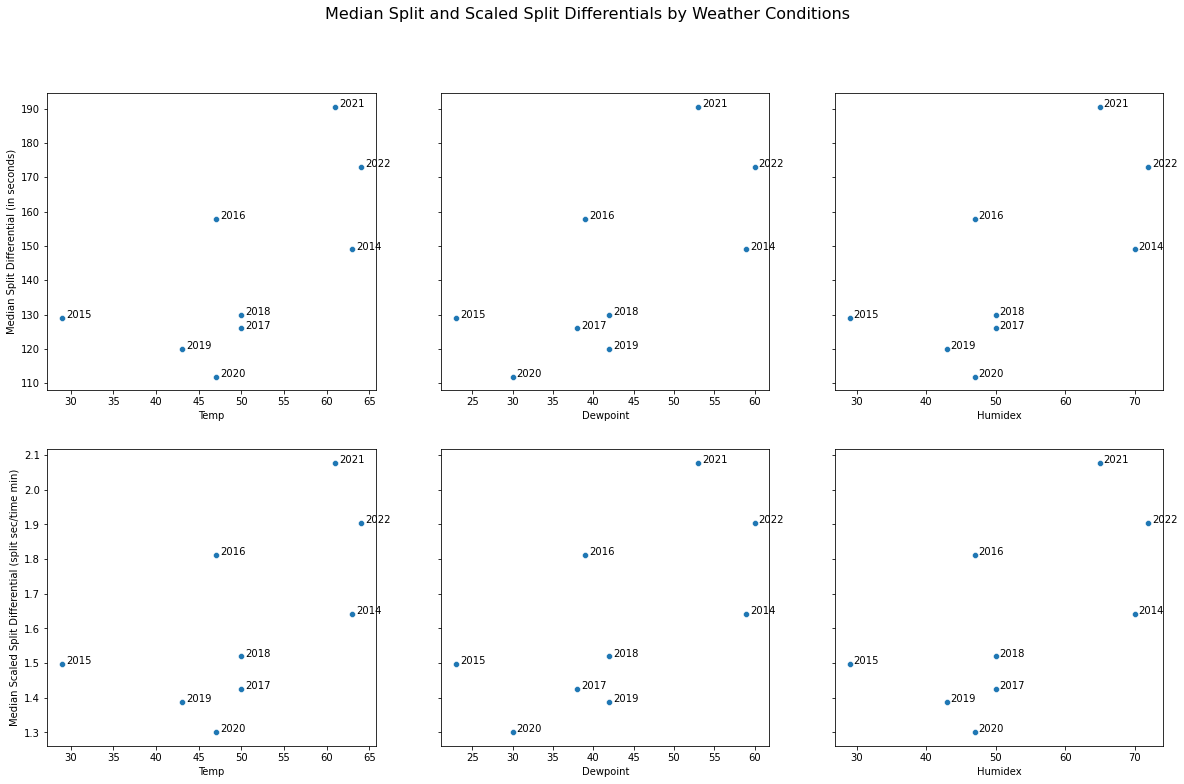

In [53]:
fig, axs = plt.subplots(2, 3, sharey='row', figsize=(20,12));
weather_vars = ['Temp', 'Dewpoint', 'Humidex']

for k in range(3):
    sns.scatterplot(data=year_aggs, x=weather_vars[k], y='Half_diff_sec_median', ax=axs[0][k]);
    label_point(year_aggs[weather_vars[k]], year_aggs['Half_diff_sec_median'],
                year_aggs['Year'].astype(str), axs[0][k]);
axs[0][0].set_ylabel('Median Split Differential (in seconds)');

for k in range(3):
    sns.scatterplot(data=year_aggs, x=weather_vars[k], y='Split_scaled_median', ax=axs[1][k]);
    label_point(year_aggs[weather_vars[k]], year_aggs['Split_scaled_median'],
                year_aggs['Year'].astype(str), axs[1][k]);
axs[1][0].set_ylabel('Median Scaled Split Differential (split sec/time min)');

fig.suptitle('Median Split and Scaled Split Differentials by Weather Conditions', fontsize=16);

## Miscellaneous

The following shows that there might be a slight positive correlation between overall time and scaled split, but of course less than in the unscaled version.

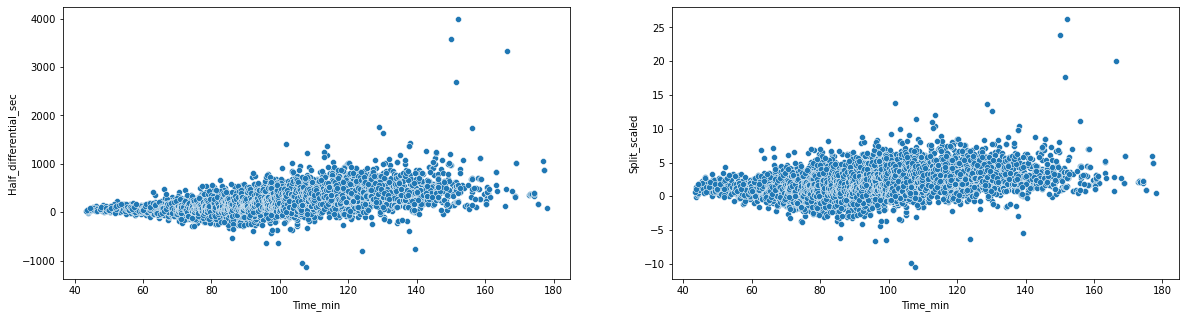

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5));
sns.scatterplot(data=df, x='Time_min', y='Half_differential_sec', ax=ax1);
sns.scatterplot(data=df, x='Time_min', y='Split_scaled', ax=ax2);

Here's just another graph using some variables that were not considered above. This shows that most people had two consecutive positive 5k split differentials, some had mixed, and very few had consecutive negative splits.

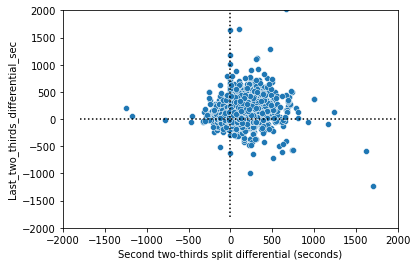

In [55]:
g = sns.scatterplot(x='First_two_thirds_differential_sec', y='Last_two_thirds_differential_sec', data=df)
plt.xlabel('First two-thirds split differential (seconds)')
plt.xlabel('Second two-thirds split differential (seconds)')
g.set_xlim(-2000,2000);
g.set_ylim(-2000,2000);
g.plot(np.linspace(-1800, 2000), np.zeros(50), ':k');
g.plot(np.zeros(50), np.linspace(-1800, 2000), ':k');

# Regression Analysis

## Preparing Data for Regression Analysis

We'll do best-subset regression analysis on two responses: time and split differential.

In [56]:
"""Pares the datasets down to just the variables we need, drops missing values, makes Gender into a 0-1 variable."""

gender_dummy = pd.get_dummies(df['Gender'], drop_first=True)

predictors_time = ['Age', 'Humidex']
df_ = df[predictors_time + ['Time_min']]
df_time = pd.concat([gender_dummy, df_], axis=1).dropna()

X_time = df_time[['M'] + predictors_time]
X_time = sm.add_constant(X_time)
y_time = pd.DataFrame(df_time['Time_min'])

predictors_split = ['Age', 'Humidex', 'Time_min']
df_ = df[predictors_split + ['Half_differential_sec']]
df_split = pd.concat([gender_dummy, df_], axis=1).dropna()

X_split = df_split[['M'] + predictors_split]
X_split = sm.add_constant(X_split)
y_split = pd.DataFrame(df_split['Half_differential_sec'])

print(X_time.shape, y_time.shape, X_split.shape, y_split.shape)

(9528, 4) (9528, 1) (9452, 5) (9452, 1)


## Regression Analysis

In [57]:
"""Splits training data into 10 folds for cross validation, fits a least squares linear model on the fold training
set, and computes RMSE using the fold test set predictions. Returns the mean and the std dev of the RMSEs across
the folds."""

from sklearn.model_selection import KFold

def cross_validate_time(num_splits=10, predictors=['M', 'Age', 'Humidex', 'const']):
    X = X_time[predictors].copy()
    y = y_time.copy()
    folds = KFold(n_splits=num_splits, shuffle=True, random_state=4).split(X, y)
    RMSErrors = np.zeros(num_splits)
    for k, (train_ind, val_ind) in enumerate(folds):
        X_train_k = X.iloc[train_ind]
        y_train_k = y.iloc[train_ind]['Time_min']
        X_val_k = X.iloc[val_ind]
        y_val_k = y.iloc[val_ind]['Time_min']
        results = sm.OLS(y_train_k, X_train_k).fit()
        RMSE = (((results.predict(X_val_k) - y_val_k) ** 2).sum() / len(y_val_k)) ** (1/2)
        RMSErrors[k] = RMSE
    return (RMSErrors.mean(), RMSErrors.std())

def cross_validate_split(num_splits=10, predictors=['M', 'Age', 'Humidex', 'Time_min', 'const']):
    X = X_split[predictors].copy()
    y = y_split.copy()
    folds = KFold(n_splits=num_splits, shuffle=True, random_state=4).split(X, y)
    RMSErrors = np.zeros(num_splits)
    for k, (train_ind, val_ind) in enumerate(folds):
        X_train_k = X.iloc[train_ind]
        y_train_k = y.iloc[train_ind]['Half_differential_sec']
        X_val_k = X.iloc[val_ind]
        y_val_k = y.iloc[val_ind]['Half_differential_sec']
        results = sm.OLS(y_train_k, X_train_k).fit()
        RMSE = (((results.predict(X_val_k) - y_val_k) ** 2).sum() / len(y_val_k)) ** (1/2)
        RMSErrors[k] = RMSE
    return (RMSErrors.mean(), RMSErrors.std())

The next cell goes through the cross-validation process with every subset of the predictors 'M', 'Age', 'Humidex', 'const', then ranks the results according to cross-validated RMSE. The variable set ('M', 'Age', 'const') performs the best, and the smallest within one SE of the best is ('M', 'const'). Note that 'Humidex' alone is worse than constant predictor, and makes the best predictor slightly worse when thrown in. Also, understandably, a constant in the model uniformly helps a lot.

The main interesting conclusion from this, the regression results printed above, and the visualizations above that seem to be that the weather has no significant effect whatsoever on overall time, which was quite surprising to me.

In [58]:
from itertools import combinations
from collections import defaultdict

predictors = ['M', 'Age', 'Humidex', 'const']
cv_results = defaultdict(list)

for k in range(1, 5):
    for predictor_subset in combinations(predictors, k):
        mean, std = cross_validate_time(10, list(predictor_subset))
        cv_results[predictor_subset].extend([mean, std])

cv_results_df = pd.DataFrame.from_dict(cv_results, orient='index', columns=['CV RMSE', 'SE'])

cv_results_df.sort_values(by='CV RMSE')

,CV RMSE,SE
"(M, Age, const)",19.194929,0.581765
"(M, Age, Humidex, const)",19.195909,0.582185
"(M, Humidex, const)",19.678857,0.565513
"(M, const)",19.679438,0.564248
"(Age, const)",20.490736,0.536276
"(Age, Humidex, const)",20.492847,0.536510
"(const,)",20.891586,0.513960
"(Humidex, const)",20.892793,0.515952
"(M, Age, Humidex)",25.536961,0.702492
"(Age, Humidex)",25.977312,0.709420


To finish off the analysis of overall time, we look at full results from the best subset. Unsurprisingly, being male is correlated with faster times and being older is correlated with slower times.

In [59]:
Xy_time = pd.concat([X_time, y_time], axis=1)

results_time = smf.ols(formula='Time_min ~ M + Age', data = Xy_time).fit()

print(results_time.summary())

                            OLS Regression Results                            
Dep. Variable:               Time_min   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     879.2
Date:                Tue, 16 Aug 2022   Prob (F-statistic):               0.00
Time:                        00:22:40   Log-Likelihood:                -41674.
No. Observations:                9528   AIC:                         8.335e+04
Df Residuals:                    9525   BIC:                         8.337e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     88.0709      0.648    135.943      0.0

Now on to splits. Overall time is included more as a control than a predictor (the idea being that a 2-minute positive split for somebody who runs 45 minutes is much worse than a 2-minute positive split for a person running 2 hours). After controlling for time, the full set 'M', 'Age', and 'Humidex' performs the best, and the simplest within one SE of the best is simply 'Age', with 'M' very close behind. Unsurprisingly, 'Time_min' appears to be the most helpful variable, and after 'Time_min' is in, a constant always helps (it was unclear to me that this be the case -- it seems somewhat reasonable that split should be purely proportional to time with adjustments for other variables).

In [60]:
predictors = ['M', 'Age', 'Humidex', 'Time_min', 'const']
cv_results = defaultdict(list)

for k in range(1,6):
    for predictor_subset in combinations(predictors, k):
        mean, std = cross_validate_split(10, list(predictor_subset))
        cv_results[predictor_subset].extend([mean, std])

cv_results_df = pd.DataFrame.from_dict(cv_results, orient='index', columns=['CV RMSE', 'SE'])

cv_results_df.sort_values(by='CV RMSE')

,CV RMSE,SE
"(M, Age, Humidex, Time_min, const)",176.275400,14.294624
"(M, Age, Time_min, const)",176.531580,14.168901
"(Age, Humidex, Time_min, const)",176.857845,14.846535
"(Age, Time_min, const)",177.128578,14.703946
"(M, Humidex, Time_min, const)",177.294176,14.776216
"(M, Time_min, const)",177.522253,14.637054
"(Humidex, Time_min, const)",177.717938,15.211891
"(Time_min, const)",177.960583,15.060453
"(Age, Humidex, Time_min)",184.657575,14.424323
"(M, Age, Humidex, Time_min)",184.662252,14.554198


The results for the best subset ('M', 'Age', 'Humidex', 'Time_min', 'const') are below (again). Very interestingly, the coefficient for 'M' is rather large and positive, indicating that for fixed age, weather, and time, males have more positive splits than females. This seems to directly contradict the graphs above for scaled split. We investigate this further below.

In [61]:
Xy_split = pd.concat([X_split, y_split], axis=1)

results_split = smf.ols(formula='Half_differential_sec ~ M + Age + Humidex + Time_min', data = Xy_split).fit()

print(results_split.summary())

                              OLS Regression Results                             
Dep. Variable:     Half_differential_sec   R-squared:                       0.315
Model:                               OLS   Adj. R-squared:                  0.315
Method:                    Least Squares   F-statistic:                     1088.
Date:                   Tue, 16 Aug 2022   Prob (F-statistic):               0.00
Time:                           00:22:42   Log-Likelihood:                -62319.
No. Observations:                   9452   AIC:                         1.246e+05
Df Residuals:                       9447   BIC:                         1.247e+05
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -380.7056 

To simplify this a bit, let's predict split using just 'M' and 'Time_min':

In [62]:
results_split = smf.ols(formula='Half_differential_sec ~ M + Time_min', data = Xy_split).fit()

print(results_split.summary())

                              OLS Regression Results                             
Dep. Variable:     Half_differential_sec   R-squared:                       0.305
Model:                               OLS   Adj. R-squared:                  0.305
Method:                    Least Squares   F-statistic:                     2074.
Date:                   Tue, 16 Aug 2022   Prob (F-statistic):               0.00
Time:                           00:22:42   Log-Likelihood:                -62390.
No. Observations:                   9452   AIC:                         1.248e+05
Df Residuals:                       9449   BIC:                         1.248e+05
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -379.8774 

Now predict scaled split with just 'M':

In [63]:
gender_dummy = pd.get_dummies(df['Gender'], drop_first=True)

df_ = df[['Split_scaled']]
df_scsplit = pd.concat([gender_dummy, df_], axis=1).dropna()

X_scsplit = df_scsplit[['M']]
y_scsplit = pd.DataFrame(df_scsplit['Split_scaled'])

Xy_scsplit = pd.concat([X_scsplit, y_scsplit], axis=1)

results_scsplit = smf.ols(formula='Split_scaled ~ M', data = Xy_scsplit).fit()

print(results_scsplit.summary())

                            OLS Regression Results                            
Dep. Variable:           Split_scaled   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     65.50
Date:                Tue, 16 Aug 2022   Prob (F-statistic):           6.51e-16
Time:                        00:22:42   Log-Likelihood:                -19112.
No. Observations:                9456   AIC:                         3.823e+04
Df Residuals:                    9454   BIC:                         3.824e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9513      0.025     76.819      0.0

The following is a very similar model to the 'Split_scaled ~ M' one above. The difference is that here, errors are assumed to be iid, but in the above model, errors are assumed to be proportional to time. The latter seems like a more reasonable assumption to me, but either way, we get similar coefficients.

In [64]:
print(smf.ols(formula='Half_differential_sec ~ M:Time_min + Time_min - 1', data = Xy_split).fit().summary())

                                  OLS Regression Results                                  
Dep. Variable:     Half_differential_sec   R-squared (uncentered):                   0.537
Model:                               OLS   Adj. R-squared (uncentered):              0.537
Method:                    Least Squares   F-statistic:                              5483.
Date:                   Tue, 16 Aug 2022   Prob (F-statistic):                        0.00
Time:                           00:22:42   Log-Likelihood:                         -63156.
No. Observations:                   9452   AIC:                                  1.263e+05
Df Residuals:                       9450   BIC:                                  1.263e+05
Df Model:                              2                                                  
Covariance Type:               nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

Now we repeat the previous one, but allow the constant. This changes the sign of the coefficient by 'M:Time_min', which is interesting. This probably is a more appropriate model, since in all the cross-validated models above, adding a constant improved prediction.

In [65]:
print(smf.ols(formula='Half_differential_sec ~ M:Time_min + Time_min', data = Xy_split).fit().summary())

                              OLS Regression Results                             
Dep. Variable:     Half_differential_sec   R-squared:                       0.305
Model:                               OLS   Adj. R-squared:                  0.305
Method:                    Least Squares   F-statistic:                     2073.
Date:                   Tue, 16 Aug 2022   Prob (F-statistic):               0.00
Time:                           00:22:42   Log-Likelihood:                -62391.
No. Observations:                   9452   AIC:                         1.248e+05
Df Residuals:                       9449   BIC:                         1.248e+05
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -365.7800 

Here are the cross-validated checks on the three models above. This verifies that split ~ M:time + time, or nearly equivalently, split/time = M + const, is not a very good, predictive model for this dataset.

In [66]:
X_split['M:Time_min'] = X_split['M'] * X_split['Time_min']

cv_results = defaultdict(list)

for predictor_subset in [('M', 'Time_min', 'const'),
                         ('M', 'Time_min', 'M:Time_min', 'const'),
                         ('M:Time_min', 'Time_min'),
                         ('M:Time_min', 'Time_min', 'const')]:
    mean, std = cross_validate_split(10, list(predictor_subset))
    cv_results[predictor_subset].extend([mean, std])

cv_results_df = pd.DataFrame.from_dict(cv_results, orient='index', columns=['CV RMSE', 'SE'])

cv_results_df.sort_values(by='CV RMSE')

,CV RMSE,SE
"(M, Time_min, const)",177.522253,14.637054
"(M:Time_min, Time_min, const)",177.545615,14.587696
"(M, Time_min, M:Time_min, const)",177.583259,14.656188
"(M:Time_min, Time_min)",192.438668,16.127888


The following shows that the interaction term 'M:Time_min' is not really useful in the model at all.

In [67]:
print(smf.ols(formula='Half_differential_sec ~ M*Time_min', data = Xy_split).fit().summary())

                              OLS Regression Results                             
Dep. Variable:     Half_differential_sec   R-squared:                       0.305
Model:                               OLS   Adj. R-squared:                  0.305
Method:                    Least Squares   F-statistic:                     1382.
Date:                   Tue, 16 Aug 2022   Prob (F-statistic):               0.00
Time:                           00:22:42   Log-Likelihood:                -62390.
No. Observations:                   9452   AIC:                         1.248e+05
Df Residuals:                       9448   BIC:                         1.248e+05
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -374.7682 

We'll get a little deeper into figuring out what's going on the difference between controlling split for time and dividing. Here are the relevant graphs:

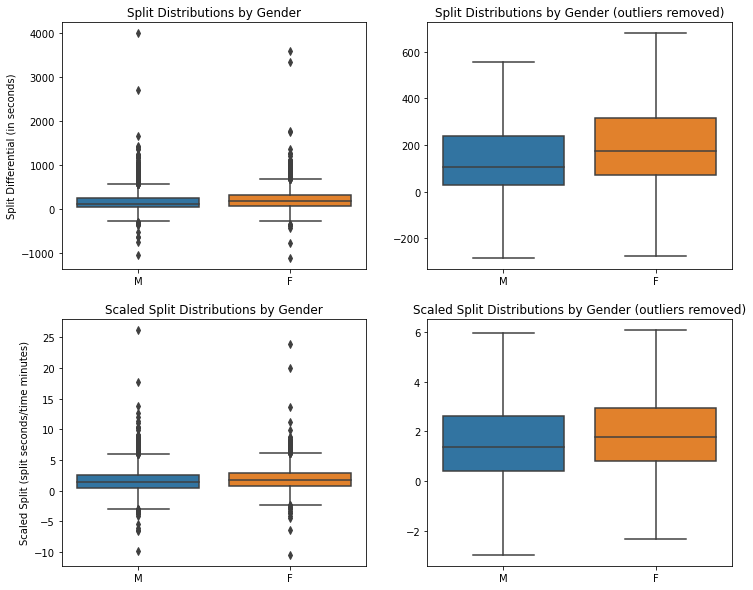

In [68]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(12,10));

sns.boxplot(data=df, x='Gender', y='Half_differential_sec', showfliers=True, ax=axs[0][0]);
axs[0][0].set_xlabel('');
axs[0][0].set_title('Split Distributions by Gender');
axs[0][0].set_ylabel('Split Differential (in seconds)');

sns.boxplot(data=df, x='Gender', y='Half_differential_sec', showfliers=False, ax=axs[0][1]);
axs[0][1].set_xlabel('');
axs[0][1].set_ylabel('');
axs[0][1].set_title('Split Distributions by Gender (outliers removed)');

sns.boxplot(data=df, x='Gender', y='Split_scaled', showfliers=True, ax=axs[1][0]);
axs[1][0].set_xlabel('');
axs[1][0].set_title('Scaled Split Distributions by Gender');
axs[1][0].set_ylabel('Scaled Split (split seconds/time minutes)');

sns.boxplot(data=df, x='Gender', y='Split_scaled', showfliers=False, ax=axs[1][1]);
axs[1][1].set_xlabel('');
axs[1][1].set_ylabel('');
axs[1][1].set_title('Scaled Split Distributions by Gender (outliers removed)');

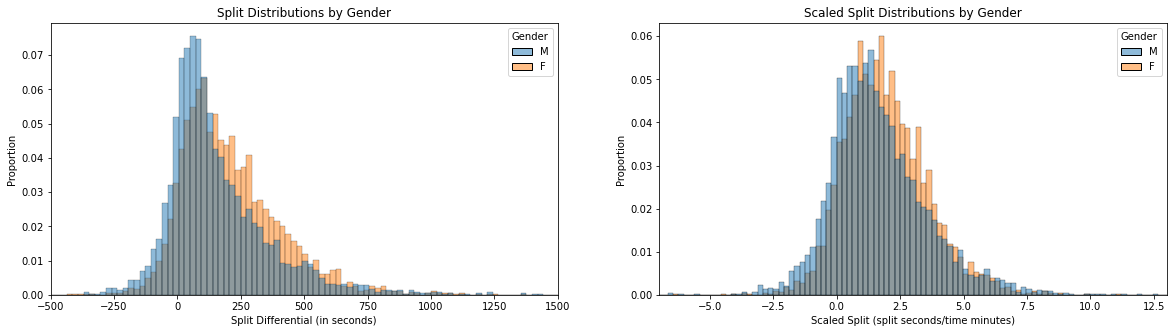

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20,5));

sns.histplot(data=df, x='Half_differential_sec', hue='Gender', stat='proportion', common_norm=False, ax=ax1);
ax1.set_xlim(-500, 1500);
ax1.set_xlabel('Split Differential (in seconds)');
ax1.set_title('Split Distributions by Gender');

sns.histplot(data=df, x='Split_scaled', hue='Gender', stat='proportion', common_norm=False, ax=ax2);
ax2.set_xlim(-7, 13);
ax2.set_xlabel('Scaled Split (split seconds/time minutes)');
ax2.set_title('Scaled Split Distributions by Gender');

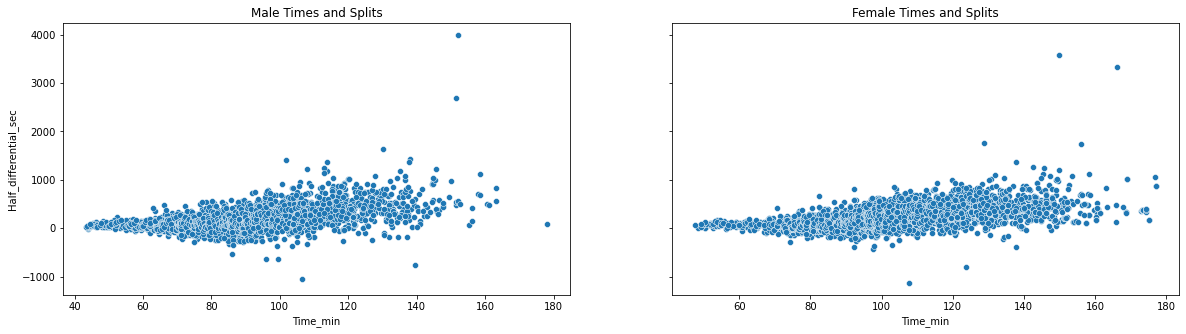

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,5));

sns.scatterplot(data=df[df['Gender']=='M'], x='Time_min', y='Half_differential_sec', ax=ax1);
ax1.set_title('Male Times and Splits');
sns.scatterplot(data=df[df['Gender']=='F'], x='Time_min', y='Half_differential_sec', ax=ax2);
ax2.set_title('Female Times and Splits');

Here, we get a clearer graph of the above. We bucket time into one-minute intervals, find the median split for each time and each gender, and graph these on one plot.

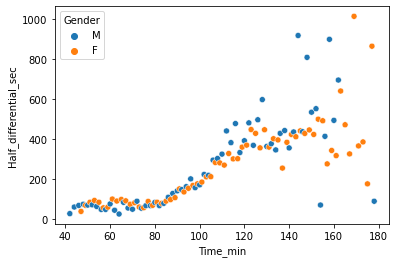

In [71]:
df_tb = df[['Gender', 'Time_min', 'Half_differential_sec', 'Age', 'Humidex']].dropna().copy()
male_mask, female_mask = df_tb['Gender'] == 'M', df_tb['Gender'] == 'F'
bucket_width = 2
offset = bucket_width / 2
df_tb.loc[male_mask, 'Time_min'] = bucket_width * (df_tb['Time_min'] // bucket_width)
df_tb.loc[female_mask, 'Time_min'] = bucket_width * ((df_tb['Time_min'] + offset) // bucket_width) - offset
split_medians = df_tb.groupby(['Time_min', 'Gender'])['Half_differential_sec'].agg('median').reset_index()

sns.scatterplot(data=split_medians, x='Time_min', y='Half_differential_sec', hue='Gender');

The following truncates the data according to time cutoffs and runs a regression on the truncated and bucketed dataset.

In [72]:
split_medians_trunc = split_medians[(40 <= split_medians['Time_min']) & (split_medians['Time_min'] <= 140)].copy()
split_medians_trunc['Split_scaled'] = split_medians_trunc['Half_differential_sec'] / split_medians_trunc['Time_min']
split_medians_trunc = pd.get_dummies(split_medians_trunc, drop_first=True)

results_control = smf.ols(formula='Half_differential_sec ~ Gender_M + Time_min', data = split_medians_trunc).fit()
results_scaled = smf.ols(formula='Split_scaled ~ Gender_M', data = split_medians_trunc).fit()

print(results_control.summary(), '\n\n\n', results_scaled.summary())

                              OLS Regression Results                             
Dep. Variable:     Half_differential_sec   R-squared:                       0.809
Model:                               OLS   Adj. R-squared:                  0.805
Method:                    Least Squares   F-statistic:                     198.7
Date:                   Tue, 16 Aug 2022   Prob (F-statistic):           1.73e-34
Time:                           00:22:47   Log-Likelihood:                -540.77
No. Observations:                     97   AIC:                             1088.
Df Residuals:                         94   BIC:                             1095.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -241.0809 

After staring at the graph and experimenting around with the above regression for a bit, it seems like there is one other issue in addition to the one described above about not including a constant in the split ~ M:time + time model. The issue appears to be: male splits are slightly better than female's at faster times, and significantly worse at slower times, but not worse enough to overcome the effect of scaling. The following is a small toy example that exhibits the same property.

,M,Time,Split,Split_scaled
0,1,1,2.0,2.000000
1,0,1,3.0,3.000000
2,1,2,3.5,1.750000
3,0,2,3.4,1.700000
4,1,3,6.0,2.000000
5,0,3,4.0,1.333333


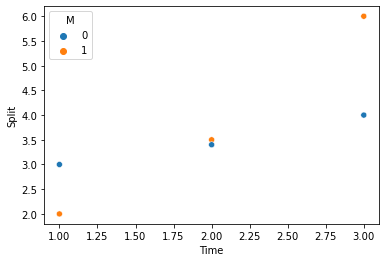

In [73]:
toy_df = pd.DataFrame([[1, 1, 2], [0, 1, 3], [1, 2, 3.5], [0, 2, 3.4], [1, 3, 6], [0, 3, 4]],
                     columns = ['M', 'Time', 'Split'])

toy_df['Split_scaled'] = toy_df['Split'] / toy_df['Time']

sns.scatterplot(data=toy_df, x='Time', y='Split', hue='M');
toy_df

In [74]:
results_control = smf.ols(formula='Split ~ M + Time', data=toy_df).fit()
results_scaled = smf.ols(formula='Split_scaled ~ M', data=toy_df).fit()

print(results_control.summary(), '\n\n\n',
      results_scaled.summary(), '\n\n\n')

                            OLS Regression Results                            
Dep. Variable:                  Split   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     3.993
Date:                Tue, 16 Aug 2022   Prob (F-statistic):              0.143
Time:                        00:22:47   Log-Likelihood:                -5.7938
No. Observations:                   6   AIC:                             17.59
Df Residuals:                       3   BIC:                             16.96
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9667      1.038      0.931      0.4

/Users/alexbearden/opt/miniconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/alexbearden/opt/miniconda3/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
